In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib
import os

df = pd.read_csv("data/raw/AB_NYC_2019.csv")
df.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [17]:
df = df.rename(columns=str.lower)

df = df.drop_duplicates()
df = df.dropna(subset=["price"])

df["price"] = df["price"].astype(float)
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,48895.0,NaN,NaN,NaN,19017143.23618,10983108.38561,2539.0,9471945.0,19677284.0,29152178.5,36487245.0
name,48879,47905,Hillside Hotel,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_id,48895.0,NaN,NaN,NaN,67620010.64661,78610967.032667,2438.0,7822033.0,30793816.0,107434423.0,274321313.0
host_name,48874,11452,Michael,417,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood_group,48895,5,Manhattan,21661,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood,48895,221,Williamsburg,3920,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,48895.0,NaN,NaN,NaN,40.728949,0.05453,40.49979,40.6901,40.72307,40.763115,40.91306
longitude,48895.0,NaN,NaN,NaN,-73.95217,0.046157,-74.24442,-73.98307,-73.95568,-73.936275,-73.71299
room_type,48895,3,Entire home/apt,25409,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,48895.0,NaN,NaN,NaN,152.720687,240.15417,0.0,69.0,106.0,175.0,10000.0


In [25]:
# Drop irrelevants
df = df.drop(columns=["id", "host_id", "host_name", "name"])

# Remove negative or zero prices
df = df[df["price"] > 0]

# Drop crazy outliers (top 1%)
df = df[df["price"] < df["price"].quantile(0.99)]

# Fill missing review counts
df["reviews_per_month"] = df["reviews_per_month"].fillna(0)

df = df.dropna()  # after fill

df.head()


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149.0,1,9,2018-10-19,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225.0,1,45,2019-05-21,0.38,2,355
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89.0,1,270,2019-07-05,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80.0,10,9,2018-11-19,0.10,1,0
5,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200.0,3,74,2019-06-22,0.59,1,129


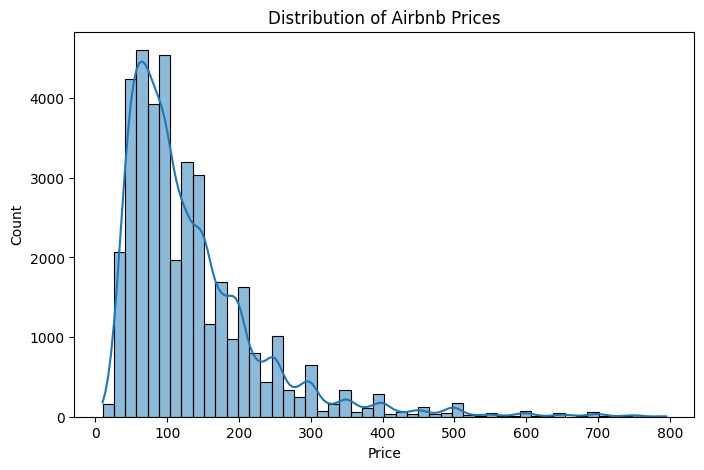

In [26]:
plt.figure(figsize=(8,5))
sns.histplot(df["price"], bins=50, kde=True)
plt.title("Distribution of Airbnb Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

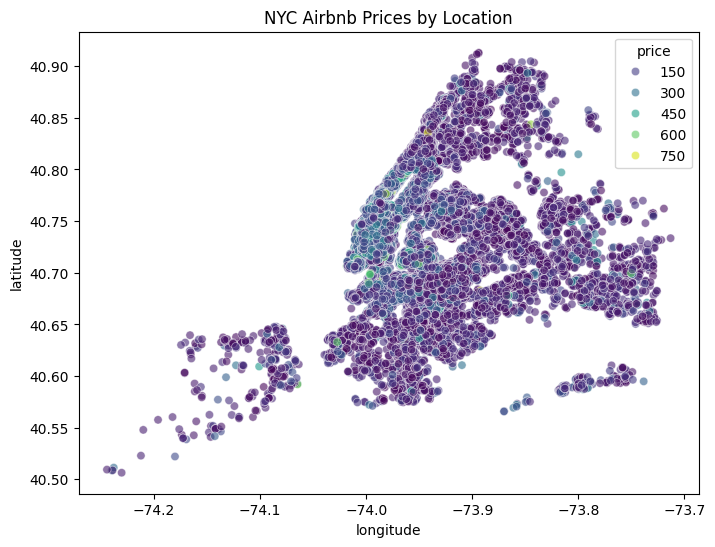

In [27]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="longitude",
    y="latitude",
    hue="price",
    data=df,
    palette="viridis",
    alpha=0.6
)
plt.title("NYC Airbnb Prices by Location")
plt.show()


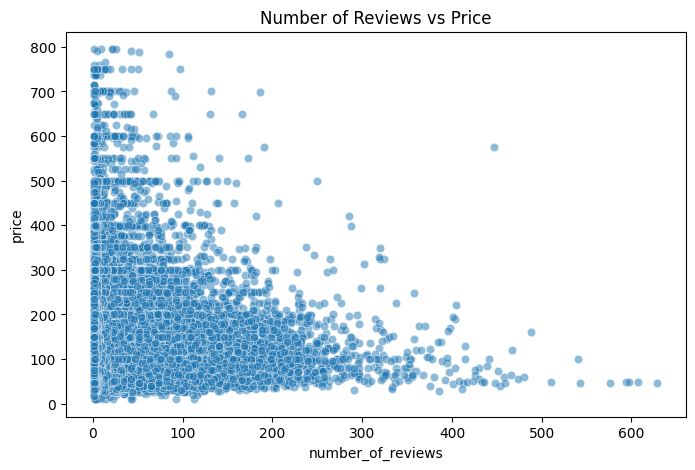

In [28]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="number_of_reviews", y="price", data=df, alpha=0.5)
plt.title("Number of Reviews vs Price")
plt.show()


In [31]:
target = "price"

features = [
    "neighbourhood_group",
    "neighbourhood",
    "latitude",
    "longitude",
    "room_type",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "availability_365"
]

data = df[features + [target]].dropna()

X = data[features]
y = data[target]

In [34]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.to_list()

numeric_features, categorical_features


(['latitude',
  'longitude',
  'minimum_nights',
  'number_of_reviews',
  'reviews_per_month',
  'availability_365'],
 ['neighbourhood_group', 'neighbourhood', 'room_type'])

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((30853, 9), (7714, 9))

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
from time import time

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    rmse = mean_squared_error(y_test, preds) ** 0.5
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append([name, rmse, mae, r2])

    results_df = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "R2"])
    results_df

In [43]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline

best_model = GradientBoostingRegressor(random_state=42)

final_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", best_model)
])

final_pipeline.fit(X, y) # Train on all data

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [44]:
import joblib
import os

os.makedirs("../models", exist_ok=True)

joblib.dump(final_pipeline, "../models/airbnb_price_model.joblib")

print("Model saved successfully.")

Model saved successfully.
